# Prediction of hit-and-run traffic accidents in Tennessee
Zimu Su

## Question/Need

A hit-and-run accident occurs when someone causes an accident and leaves the scene without providing information about themselves. It can cause severe injuries to the victims and their properties without any penalty or blame to the drivers who cause the accidents. Insurance companies might need to judge the probability of hit-and-run accident with respect to the accident situations (e.g. severity of injuries, collision type, district, etc.). The accident severity, collision situation or local public safety can be influential for a driver to decide to flee or stay. Therefore, the project assumes that most hit-and-run accidents have specific types and insurance companies can set the optimal insurance fee for the coverage of those accidents. 

## Data

The dataset is originally collected from Tennessee Integrated Traffic Analysis Network (TITAN). Each row stands for the information of a reported traffic accident. The model will predict whether an accident would be hit-and-run based on the features of accidents: number of injuries, property damage, collision type, weather condition, daylight condition, zip code.

## Tools

Python Pandas, Scikit learn, Matplotlib, Seaborn.


In [562]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (cross_val_score, train_test_split, StratifiedKFold, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score, recall_score, accuracy_score, roc_auc_score, f1_score,
                             classification_report,fbeta_score, make_scorer)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import xgboost as xgb

In [563]:
accidents = pd.read_csv('Traffic_Accidents.csv')
accidents.columns

/home/zimu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['Accident Number', 'Date and Time', 'Number of Motor Vehicles',
       'Number of Injuries', 'Number of Fatalities', 'Property Damage',
       'Hit and Run', 'Reporting Officer', 'Collision Type Code',
       'Collision Type Description', 'Weather Code', 'Weather Description',
       'Illumination Code', 'Illumination Description', 'Harmful Code',
       'Harmful Description', 'Street Address', 'City', 'State', 'ZIP', 'RPA',
       'Precinct', 'Latitude', 'Longitude', 'Mapped Location'],
      dtype='object')

### Data cleaning
NaN value in Collision Type Code, Illumination Code, Weather Code are replaced with -999, indicating unknown value.
True/False in Hit and Run is replaced with 1/0

In [607]:
df = accidents[['Hit and Run','Number of Motor Vehicles','Number of Injuries','Property Damage','Collision Type Code','Weather Code','Illumination Code','Harmful Code','ZIP']]
df = df.dropna(subset = ['Hit and Run','Number of Motor Vehicles','ZIP'])
df['Hit and Run'].replace(True, 1,inplace = True)
df['Hit and Run'].replace(False, 0,inplace = True)
df['Property Damage'].fillna(0,inplace = True)
df['Property Damage'].replace(True, 1,inplace = True)
df[['Collision Type Code','Illumination Code','Weather Code']] = df[['Collision Type Code','Illumination Code','Weather Code']].fillna(-999)
df[['Hit and Run','Number of Motor Vehicles','Property Damage','Collision Type Code','Weather Code','Illumination Code','ZIP']] = df[['Hit and Run','Number of Motor Vehicles','Property Damage','Collision Type Code','Weather Code','Illumination Code','ZIP']].astype(int)
df

,Hit and Run,Number of Motor Vehicles,Number of Injuries,Property Damage,Collision Type Code,Weather Code,Illumination Code,Harmful Code,ZIP
0,0,1,0,0,0,21,5,42;64,37210
1,1,1,0,1,0,21,1,40,37207
2,0,1,1,0,0,-999,3,11,37138
3,0,2,0,0,5,-999,4,12,37217
4,0,2,0,0,11,-999,1,12,37211
...,...,...,...,...,...,...,...,...,...
214532,0,2,0,0,4,21,3,12;30,37203
214533,1,2,0,0,5,21,2,14,37206
214534,0,3,1,0,11,21,1,12,37220
214535,0,2,1,0,9,21,1,12;99,37013


### Get dummy variables for harm code

Harm code is expanded since one accident can cause multiple harm types. The datasets have 76 harm codes in total, which is very heavy for the regression. Top 20 most frequent harm codes are selected. Other harm codes are dropped to avoid dummy trap.

In [755]:
harmdummy = df['Harmful Code'].str.split(';').str.join('|').str.get_dummies()
topharm = 5
print('Portion of top %d harm code: %.3f'% (topharm,harmdummy.sum(axis = 0).sort_values(ascending = False).head(topharm).sum()/harmdummy.sum(axis = 0).sort_values(ascending = False).sum()))
topharm = 20
print('Portion of top %d harm code: %.3f' % (topharm,harmdummy.sum(axis = 0).sort_values(ascending = False).head(topharm).sum()/harmdummy.sum(axis = 0).sort_values(ascending = False).sum()))

Portion of top 5 harm code: 0.794
Portion of top 20 harm code: 0.936


In [700]:
topharm = 20
topharmindex = harmdummy.sum(axis = 0).sort_values(ascending = False).head(topharm).index
otherharmindex = harmdummy.sum(axis = 0).sort_values(ascending = False).tail(len(harmdummy.columns) - topharm).index
topharmdummy = harmdummy[topharmindex]
topharmdummy.loc[harmdummy[otherharmindex].sum(axis = 1) >= 1, 'other'] = 1
topharmdummy.loc[harmdummy[otherharmindex].sum(axis = 1) == 0, 'other'] = 0
topharmdummy = topharmdummy[topharmdummy == 1].dropna(how='all').fillna(0)
topharmdummy = topharmdummy.add_prefix('harm_')

/home/zimu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/zimu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Get dummies for other feature and assign X and y for regression


In [701]:
ctc = pd.get_dummies(df['Collision Type Code'],prefix='collision')#drop_first = True,
wc = pd.get_dummies(df['Weather Code'],prefix='weather')
ic = pd.get_dummies(df['Illumination Code'],prefix='illum')
zc = pd.get_dummies(df['ZIP'],prefix='zip')
X = pd.concat([df[['Number of Motor Vehicles','Number of Injuries','Property Damage']],ctc,wc,ic,zc,topharmdummy],axis = 1)

y = df['Hit and Run']
X = X.apply(pd.to_numeric)
y = y.apply(pd.to_numeric)

In [702]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213424 entries, 0 to 214536
Data columns (total 90 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Number of Motor Vehicles  213424 non-null  int64  
 1   Number of Injuries        213424 non-null  int64  
 2   Property Damage           213424 non-null  int64  
 3   collision_-999            213424 non-null  uint8  
 4   collision_0               213424 non-null  uint8  
 5   collision_2               213424 non-null  uint8  
 6   collision_3               213424 non-null  uint8  
 7   collision_4               213424 non-null  uint8  
 8   collision_5               213424 non-null  uint8  
 9   collision_6               213424 non-null  uint8  
 10  collision_9               213424 non-null  uint8  
 11  collision_11              213424 non-null  uint8  
 12  collision_16              213424 non-null  uint8  
 13  collision_98              213424 non-null  u

## Feature engineering
Select features with most frequecies.

In [756]:
def grouprare(top,Xnew,X,col1,col2,name):
    name = name + '_other'
    temp = X.iloc[:,col1:col2]
    topindex = temp.sum(axis = 0).sort_values(ascending = False).head(top).index
    otherindex = temp.sum(axis = 0).sort_values(ascending = False).tail(len(temp) - top).index
    Xnew[topindex] = X[topindex]   
#     Xnew.loc[X[otherindex].sum(axis = 1) >= 1, name] = 1
#     Xnew.loc[X[otherindex].sum(axis = 1) == 0, name] = 0
    return Xnew


In [757]:
X = pd.concat([df[['Number of Motor Vehicles','Number of Injuries','Property Damage']],ctc,wc,ic,zc,topharmdummy],axis = 1)
X = X.apply(pd.to_numeric)
Xnew = pd.DataFrame()
Xnew = X.iloc[:,0:3]
ind = 3
Xnew = grouprare(len(ctc.columns),Xnew,X,ind,ind+len(ctc.columns),'collision')
ind += len(ctc.columns)
Xnew = grouprare(len(wc.columns),Xnew,X,ind,ind+len(wc.columns),'weather')
ind += len(wc.columns)
Xnew = grouprare(len(ic.columns),Xnew,X,ind,ind+len(ic.columns),'illum')
ind += len(ic.columns)
Xnew = grouprare(len(zc.columns),Xnew,X,ind,ind+len(zc.columns),'zip')
ind += len(zc.columns)
Xnew[X.iloc[:,ind:].columns] = X.iloc[:,ind:]#drop harm
X = Xnew
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213424 entries, 0 to 214536
Data columns (total 90 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Number of Motor Vehicles  213424 non-null  int64  
 1   Number of Injuries        213424 non-null  int64  
 2   Property Damage           213424 non-null  int64  
 3   collision_11              213424 non-null  uint8  
 4   collision_4               213424 non-null  uint8  
 5   collision_0               213424 non-null  uint8  
 6   collision_5               213424 non-null  uint8  
 7   collision_6               213424 non-null  uint8  
 8   collision_2               213424 non-null  uint8  
 9   collision_9               213424 non-null  uint8  
 10  collision_98              213424 non-null  uint8  
 11  collision_16              213424 non-null  uint8  
 12  collision_3               213424 non-null  uint8  
 13  collision_-999            213424 non-null  u

In [758]:
# Ratio of hit-and-run accidents in the dataset
y.sum()/len(y)

0.22358778769023166

In [759]:
har = pd.concat([df['Hit and Run'],X],axis = 1)
har.groupby('Hit and Run').sum()

,Number of Motor Vehicles,Number of Injuries,Property Damage,collision_11,collision_4,collision_0,collision_5,collision_6,collision_2,collision_9,...,harm_40,harm_55,harm_13,harm_33,harm_99,harm_50,harm_64,harm_7,harm_38,harm_other
Hit and Run,,,,,,,,,,,,,,,,,,,,,
0,312856,73063,11048,62958.0,41964.0,29717.0,21262.0,2710.0,3655.0,322.0,...,1305.0,814.0,1460.0,1385.0,297.0,1754.0,1348.0,1325.0,981.0,11208.0
1,91592,9279,4648,14587.0,9160.0,7099.0,9625.0,1955.0,880.0,2427.0,...,881.0,1225.0,335.0,397.0,1474.0,11.0,356.0,300.0,614.0,3105.0


Some EDAs to inspect the non-hit-and-run/hit-and-run accidents number.

Text(0.5, 0, 'Collision type')

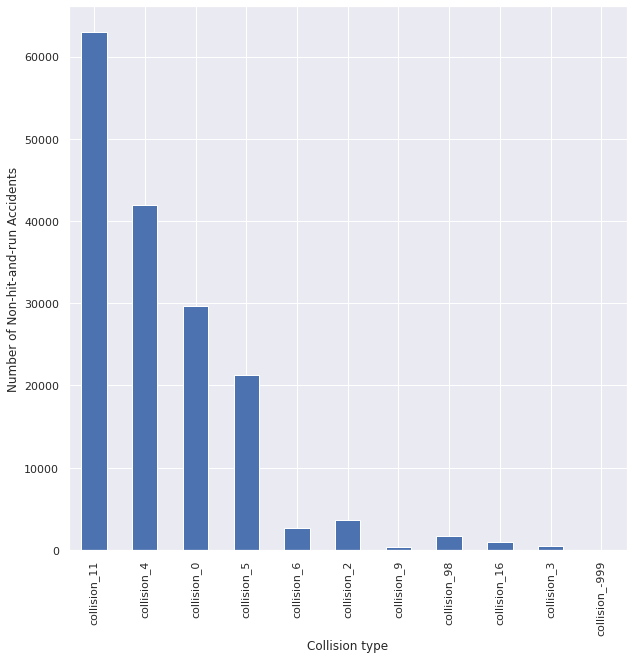

In [761]:
pyplot.rcParams['figure.figsize'] = (10,10)
har = pd.concat([df['Hit and Run'],X],axis = 1)
ind = 4
temp = har.groupby('Hit and Run')[har.columns[ind:ind+len(ctc.columns)]].sum()
ind += len(ctc.columns)
temp.iloc[0,:].plot(kind = 'bar')
plt.ylabel('Number of Non-hit-and-run Accidents')
plt.xlabel('Collision type')

Text(0.5, 0, 'Collision type')

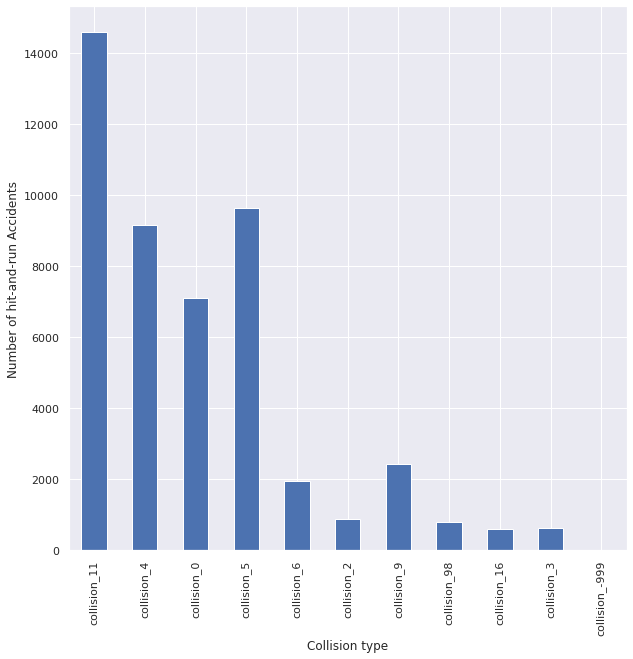

In [762]:
temp.iloc[1,:].plot(kind = 'bar')
plt.ylabel('Number of hit-and-run Accidents')
plt.xlabel('Collision type')

Text(0.5, 0, 'Weather')

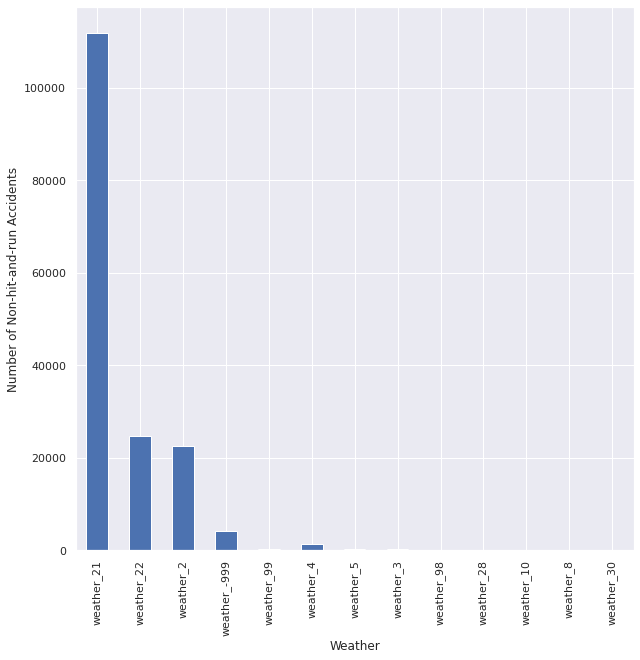

In [763]:
har = pd.concat([df['Hit and Run'],X],axis = 1)
temp = har.groupby('Hit and Run')[har.columns[ind:ind+len(wc.columns)]].sum()                                 
ind += len(wc.columns)
temp.iloc[0,:].plot(kind = 'bar')
plt.ylabel('Number of Non-hit-and-run Accidents')
plt.xlabel('Weather')

Text(0.5, 0, 'Weather type')

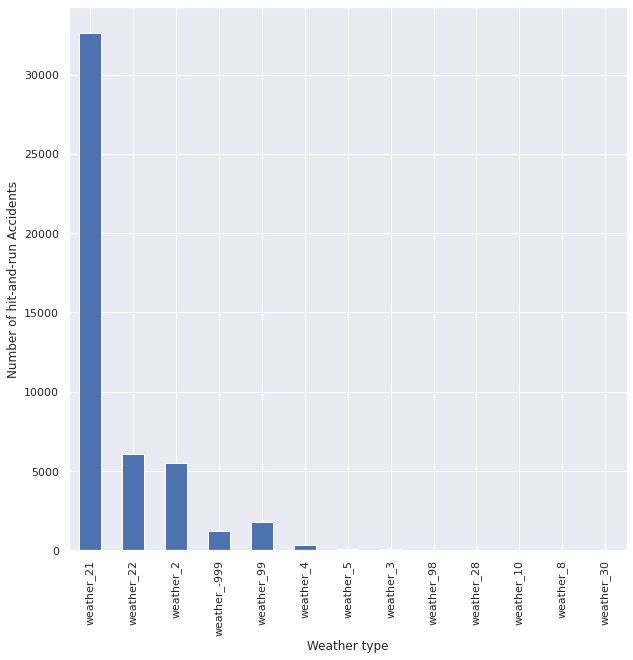

In [765]:
temp.iloc[1,:].plot(kind = 'bar')
plt.ylabel('Number of hit-and-run Accidents')
plt.xlabel('Weather type')

Text(0.5, 0, 'Illuminaion type')

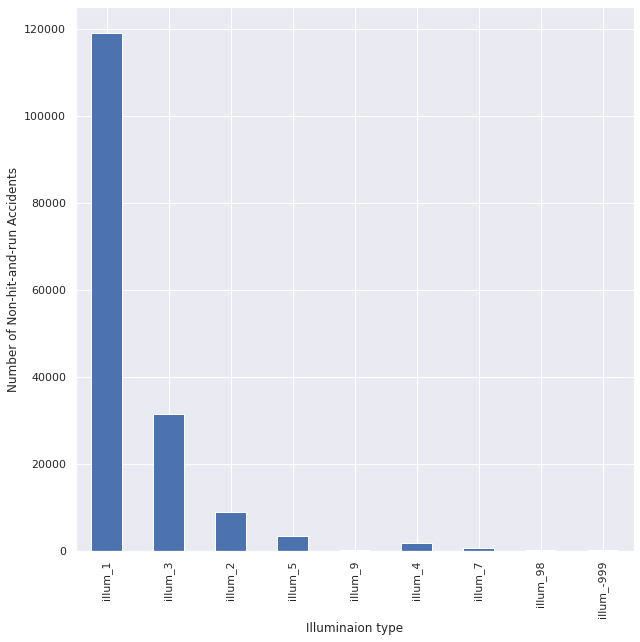

In [766]:
har = pd.concat([df['Hit and Run'],X],axis = 1)
temp = har.groupby('Hit and Run')[har.columns[ind:ind+len(ic.columns)]].sum()                                 
ind += len(ic.columns)
temp.iloc[0,:].plot(kind = 'bar')
plt.ylabel('Number of Non-hit-and-run Accidents')
plt.xlabel('Illuminaion type')

Text(0.5, 0, 'Illuminaion type')

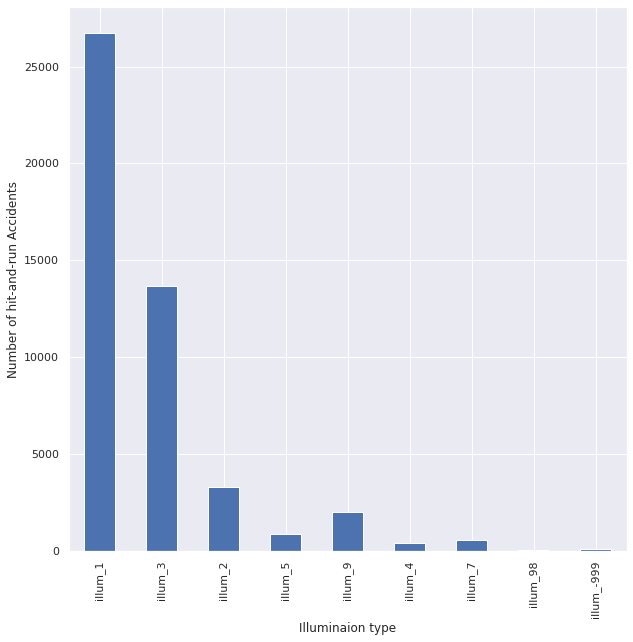

In [767]:
temp.iloc[1,:].plot(kind = 'bar')
plt.ylabel('Number of hit-and-run Accidents')
plt.xlabel('Illuminaion type')

Text(0, 0.5, 'Number of Non-hit-and-run Accidents')

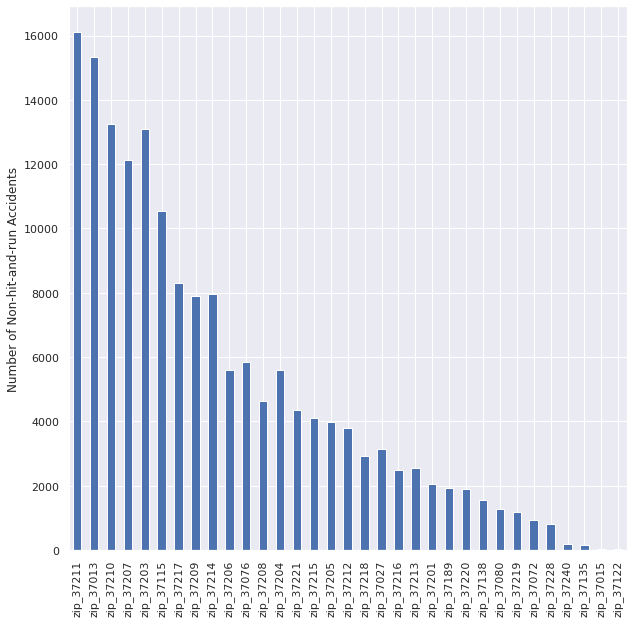

In [768]:
har = pd.concat([df['Hit and Run'],X],axis = 1)
temp = har.groupby('Hit and Run')[har.columns[ind:ind+len(zc.columns)]].sum()                                 
ind += len(zc.columns)
temp.iloc[0,:].plot(kind = 'bar')
plt.ylabel('Number of Non-hit-and-run Accidents')

Text(0.5, 0, 'Illuminaion type')

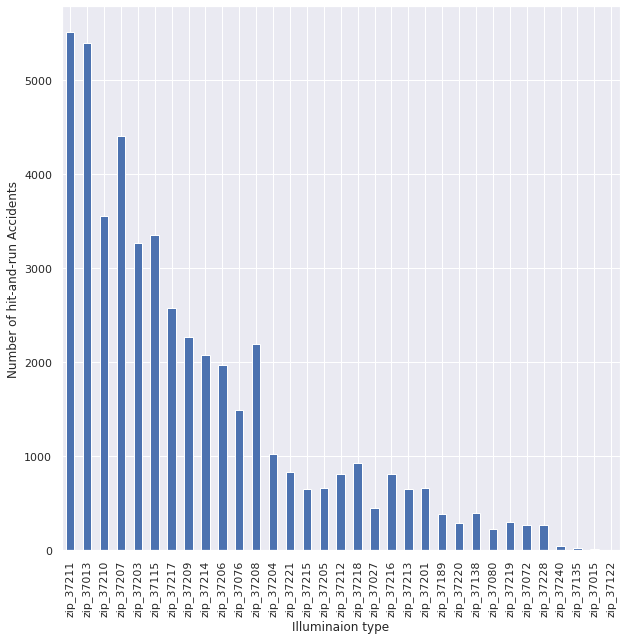

In [769]:
temp.iloc[1,:].plot(kind = 'bar')
plt.ylabel('Number of hit-and-run Accidents')
plt.xlabel('Illuminaion type')

Text(0, 0.5, 'Number of Non-hit-and-run Accidents')

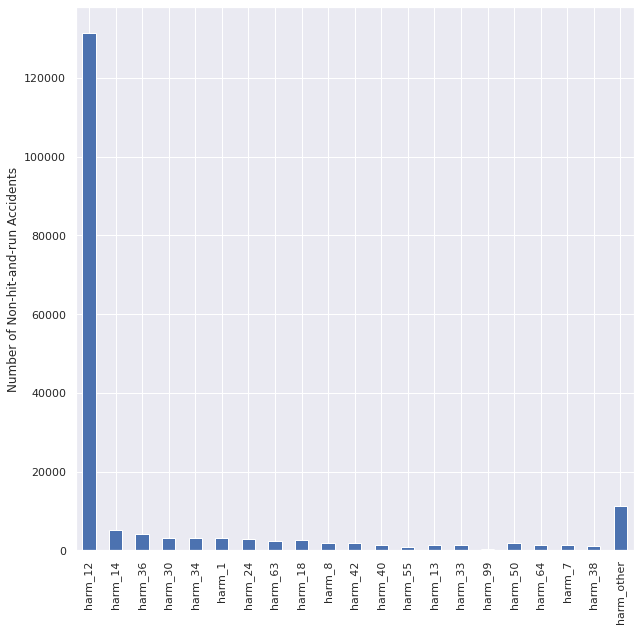

In [770]:
har = pd.concat([df['Hit and Run'],X],axis = 1)
temp = har.groupby('Hit and Run')[har.columns[ind:]].sum()                                 
temp.iloc[0,:].plot(kind = 'bar')
plt.ylabel('Number of Non-hit-and-run Accidents')

Text(0, 0.5, 'Number of hit-and-run Accidents')

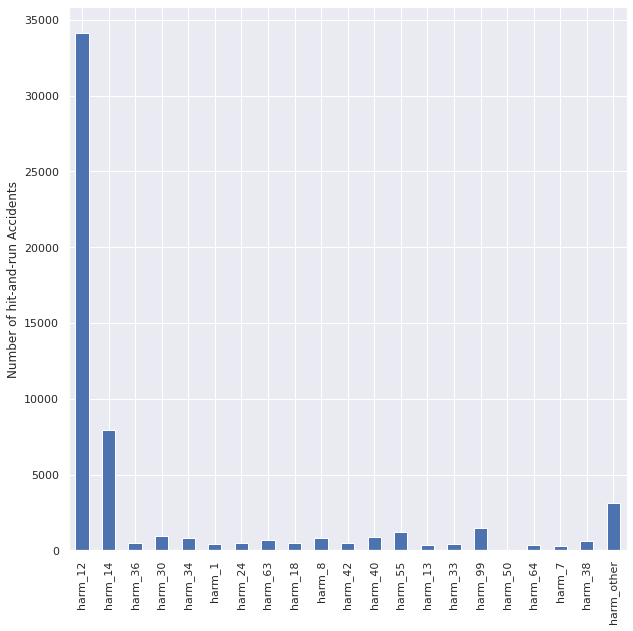

In [771]:
temp.iloc[1,:].plot(kind = 'bar')
plt.ylabel('Number of hit-and-run Accidents')

In [772]:
ind = 4
har.groupby('Hit and Run')[har.columns[ind:ind+len(ctc.columns)]].sum().transpose().to_csv('collision_stat.csv')
ind += len(ctc.columns)
har.groupby('Hit and Run')[har.columns[ind:ind+len(wc.columns)]].sum().transpose().to_csv('weather_stat.csv')
ind += len(wc.columns)
har.groupby('Hit and Run')[har.columns[ind:ind+len(ic.columns)]].sum().transpose().to_csv('illum_stat.csv')
ind += len(ic.columns)
har.groupby('Hit and Run')[har.columns[ind:ind+len(zc.columns)]].sum().transpose().to_csv('zip_stat.csv')
ind += len(zc.columns)
har.groupby('Hit and Run')[har.columns[ind:]].sum().transpose().to_csv('harm_stat.csv')

Only the least frequent column is dropped for each feature.

In [774]:
X = pd.concat([df[['Number of Motor Vehicles','Number of Injuries','Property Damage']],ctc,wc,ic,zc,topharmdummy],axis = 1)
X = X.apply(pd.to_numeric)
Xnew = pd.DataFrame()
Xnew = X.iloc[:,0:3]
ind = 3
Xnew = grouprare(len(ctc.columns)-1,Xnew,X,ind,ind+len(ctc.columns),'collision')
ind += len(ctc.columns)
Xnew = grouprare(len(wc.columns)-1,Xnew,X,ind,ind+len(wc.columns),'weather')
ind += len(wc.columns)
Xnew = grouprare(len(ic.columns)-1,Xnew,X,ind,ind+len(ic.columns),'illum')
ind += len(ic.columns)
Xnew = grouprare(len(zc.columns)-1,Xnew,X,ind,ind+len(zc.columns),'zip')
ind += len(zc.columns)
Xnew[X.iloc[:,ind:-2].columns] = X.iloc[:,ind:-2]#drop harm
X = Xnew
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213424 entries, 0 to 214536
Data columns (total 84 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Number of Motor Vehicles  213424 non-null  int64  
 1   Number of Injuries        213424 non-null  int64  
 2   Property Damage           213424 non-null  int64  
 3   collision_11              213424 non-null  uint8  
 4   collision_4               213424 non-null  uint8  
 5   collision_0               213424 non-null  uint8  
 6   collision_5               213424 non-null  uint8  
 7   collision_6               213424 non-null  uint8  
 8   collision_2               213424 non-null  uint8  
 9   collision_9               213424 non-null  uint8  
 10  collision_98              213424 non-null  uint8  
 11  collision_16              213424 non-null  uint8  
 12  collision_3               213424 non-null  uint8  
 13  weather_21                213424 non-null  u

### Logistic regression

Split the dataset to train and test.

In [747]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

Standardize the train dataset.

In [748]:
std = StandardScaler()
std.fit(X_train[['Number of Motor Vehicles','Number of Injuries']].values)
X_train[['Number of Motor Vehicles','Number of Injuries']] = std.transform(X_train[['Number of Motor Vehicles','Number of Injuries']].values)
X_test[['Number of Motor Vehicles','Number of Injuries']] = std.transform(X_test[['Number of Motor Vehicles','Number of Injuries']].values)

/home/zimu/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/home/zimu/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [658]:
def threholdplot(X_test, y_test,model):

    %matplotlib inline

    sns.set()

    X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

    thresh_ps = np.linspace(.10,0.7,1000)
    model_val_probs = model.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(y_val, model_val_labels))    
        prec_scores.append(precision_score(y_val, model_val_labels))
        rec_scores.append(recall_score(y_val, model_val_labels))
        acc_scores.append(accuracy_score(y_val, model_val_labels))

    plt.plot(thresh_ps, f1_scores)
    plt.plot(thresh_ps, prec_scores)
    plt.plot(thresh_ps, rec_scores)
    plt.plot(thresh_ps, acc_scores)

    plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
    plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
    plt.xlabel('P threshold')
    plt.ylabel('Metric score')

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))
    
def get_tpr(y_test, preds):
    tp = ((y_test == 1) & (preds == 1)).sum()
    fn = ((y_test == 1) & (preds == 0)).sum()
    tpr = tp /  (tp + fn)
    return tpr

def get_fpr(y_test, preds):
    fp = ((y_test == 0) & (preds == 1)).sum()
    tn = ((y_test == 0) & (preds == 0)).sum()
    tpr = fp / (fp + tn)
    return tpr

def roc(y_test, preds_probs, thresholds,color):
    tprs = []
    fprs = []
    for threshold in thresholds:
        preds = (preds_probs[:,1] > threshold).astype(int)
        tpr = get_tpr(y_test, preds)
        fpr = get_fpr(y_test, preds)
        tprs.append(tpr)
        fprs.append(fpr)       

    pyplot.rcParams['figure.figsize'] = (10,10)
    plt.plot(fprs, tprs,color)
    plt.legend(['Balanced','Imbalanced'], bbox_to_anchor=(1.05, 0), loc='lower left')
    return fprs, tprs, thresholds

Logistic regression with balanced weight:

Logistic Regression Model best F1 score 0.472 at prob decision threshold >= 0.502
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     33196
           1       0.39      0.59      0.47      9489

    accuracy                           0.71     42685
   macro avg       0.63      0.66      0.63     42685
weighted avg       0.76      0.71      0.72     42685

ROC AUC score: 0.730


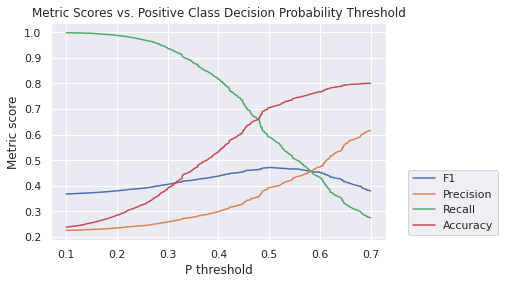

In [749]:
logmodel_ba = LogisticRegression(class_weight = 'balanced',max_iter=1e3)
logmodel_ba.fit(X_train,y_train)
threholdplot(X_test, y_test,logmodel_ba)
pred_ba = logmodel_ba.predict(X_test)
proba_ba = logmodel_ba.predict_proba(X_test)
print(classification_report(y_test,pred_ba))
print('ROC AUC score: %.3f' % roc_auc_score(y_test, proba_ba[:, 1]))

([1.0,
  0.9782805157247861,
  0.9157729846969515,
  0.7670803711290517,
  0.5444330642246054,
  0.26078443185926015,
  0.13721532714784915,
  0.04910230148210628,
  0.018556452584648754,
  0.005693457043017231],
 [1.0,
  0.9983138370745073,
  0.9877753187901781,
  0.9383496680366741,
  0.8161028559384551,
  0.5901570239224365,
  0.4328169459374012,
  0.275160712403836,
  0.18010327747918642,
  0.10907366424280746],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

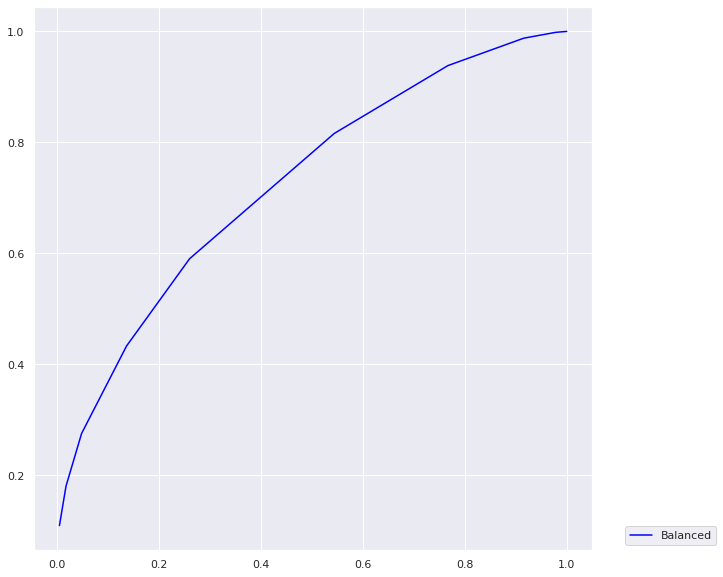

In [660]:
roc(y_test, proba_ba, thresholds,'blue')

Optimal C: 0.1
Best score at optimal C: 0.7290874794827915
Logistic Regression Model best F1 score 0.472 at prob decision threshold >= 0.503
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     33196
           1       0.39      0.59      0.47      9489

    accuracy                           0.71     42685
   macro avg       0.63      0.67      0.63     42685
weighted avg       0.76      0.71      0.72     42685

ROC AUC score: 0.730


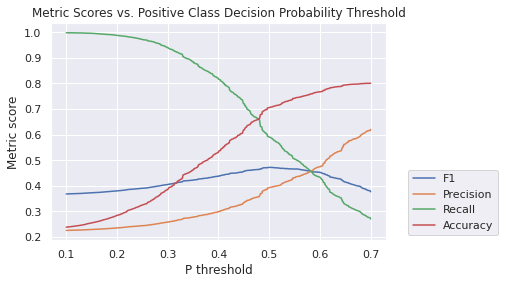

In [661]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
# clf = GridSearchCV(LogisticRegression(max_iter=1e3), param_grid, cv=None, scoring=make_scorer(fbeta_score, beta=2))
clf = GridSearchCV(LogisticRegression(max_iter=1e3,class_weight = 'balanced'), param_grid, cv=None, scoring='roc_auc')
# lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear')
clf.fit(X_train, y_train)
print('Optimal C:', clf.best_params_['C'])
print('Best score at optimal C:',clf.best_score_)
threholdplot(X_test, y_test,clf)
pred_clf = clf.predict(X_test)
proba_clf = clf.predict_proba(X_test)
print(classification_report(y_test,pred_clf))
print('ROC AUC score: %.3f' % roc_auc_score(y_test, proba_clf[:, 1]))

Regularization and modifying class weight don't help too much to increase f1 score.

Oversampling:

In [662]:
import imblearn.over_sampling

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)

lr_smote = LogisticRegression(C=0.1,solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)
print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_smote.predict(X_test)), roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:,1])))

/home/zimu/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (152920) in class 1 will be larger than the number of samples in the majority class (class #0 -> 132509)
  warnings.warn(


Logistic Regression on SMOTE Train Data; Test F1: 0.455, Test AUC: 0.722


### Random Forest Decision Tree Modeling

Logistic Regression Model best F1 score 0.456 at prob decision threshold >= 0.249
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     33196
           1       0.39      0.59      0.47      9489

    accuracy                           0.71     42685
   macro avg       0.63      0.67      0.63     42685
weighted avg       0.76      0.71      0.72     42685

ROC AUC score: 0.730


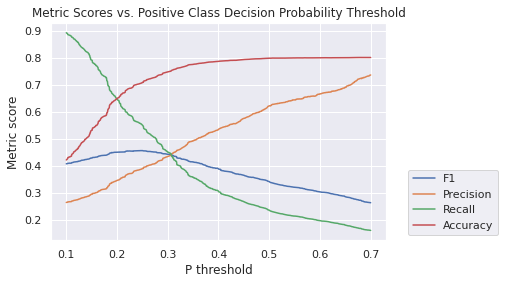

In [663]:
randomforest = RandomForestClassifier(n_estimators=1000)
randomforest.fit(X_train,y_train)
threholdplot(X_test, y_test,randomforest)
pred_rf = randomforest.predict(X_test)
proba_rf = randomforest.predict_proba(X_test)
print(classification_report(y_test,pred_clf))
print('ROC AUC score: %.3f' % roc_auc_score(y_test, proba_clf[:, 1]))

Additional feature engineering show that dropping catagories or only applying regression on single variable won't increase F1 score.

### Interpretation

The odds for unit increase of features in logistic regression are plotted using bar plot.

In [743]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
std = StandardScaler()
std.fit(X_train[['Number of Motor Vehicles','Number of Injuries']].values)
X_train[['Number of Motor Vehicles','Number of Injuries']] = std.transform(X_train[['Number of Motor Vehicles','Number of Injuries']].values)
X_test[['Number of Motor Vehicles','Number of Injuries']] = std.transform(X_test[['Number of Motor Vehicles','Number of Injuries']].values)
logmodel_ba = LogisticRegression(C=0.1,class_weight = 'balanced',max_iter=1e3)
logmodel_ba.fit(X_train,y_train)

/home/zimu/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/home/zimu/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000.0)

Acciedents with 

harm type of 
'UNKNOWN MOST HARMFUL EVENT', 
'Motor Vehicle-In-Motion Outside Traffic',
'Mail Box', 'pedestrain', 
'PARKED MOTOR VEHICLE' 

illumination conditions of 
'Dark-Unknown Lighting',
'Unknown'

cloudy weather

collision type of
'REAR-TO-REAR',
'SIDESWIPE - OPPOSITE DIRECTION'
'UNKNOWN'

have more possibility to be hit-and-run.

Besides, hit-and-run accidents tend to cause property damage.

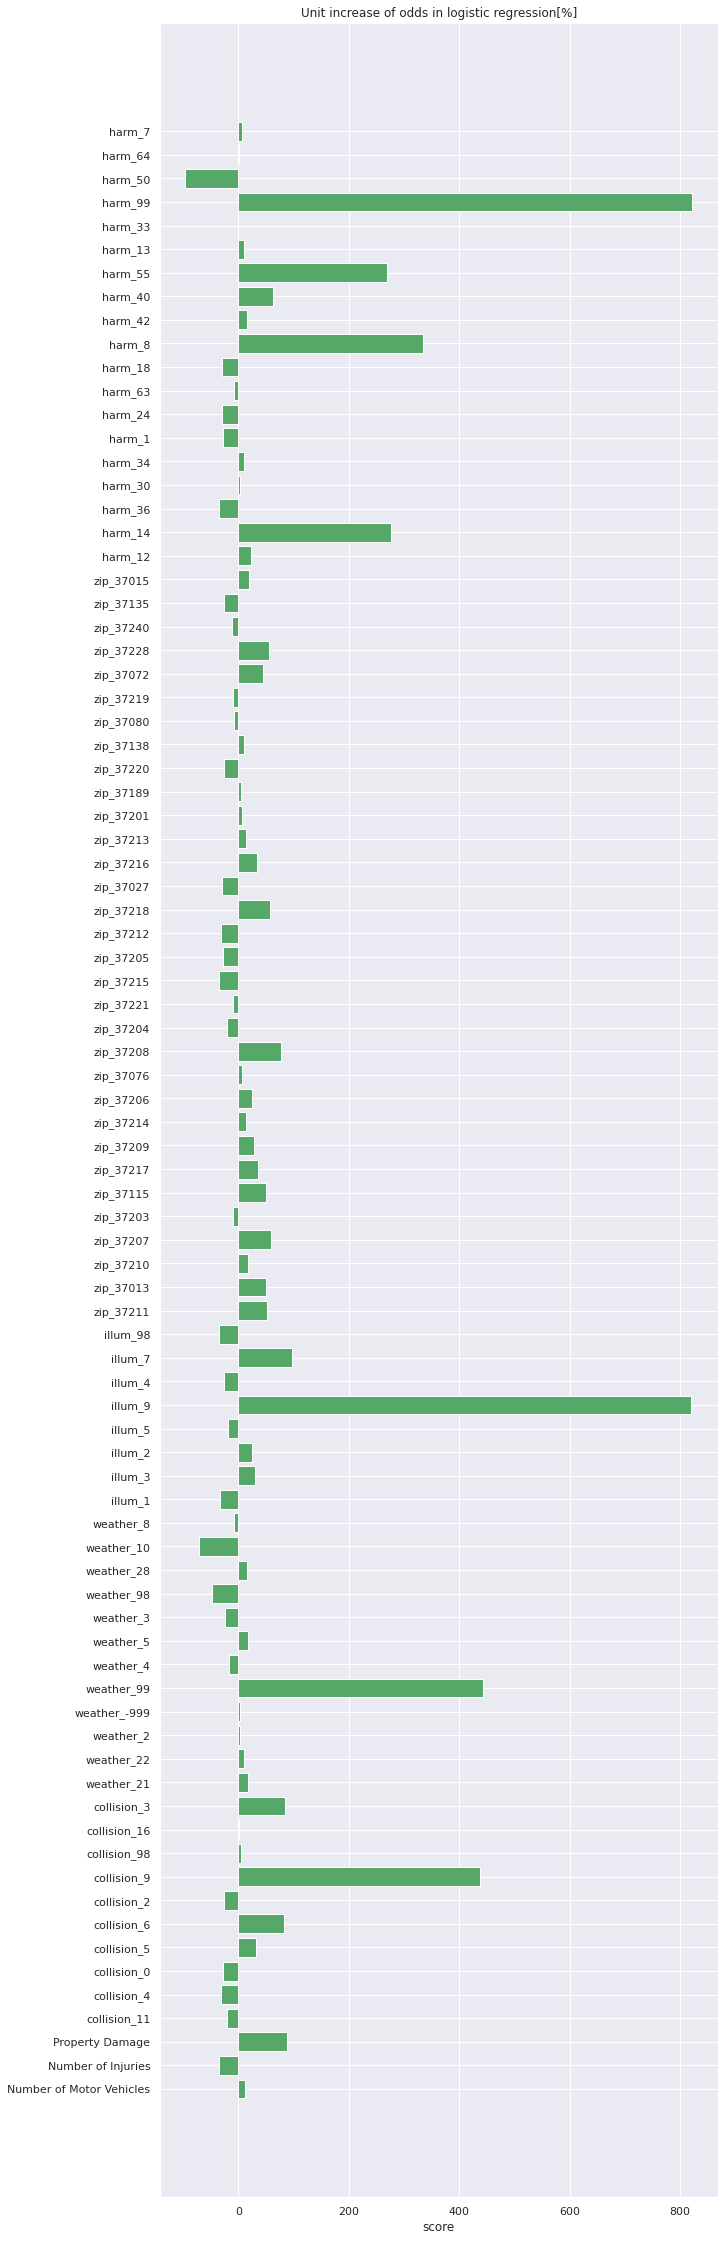

In [674]:
odds = (np.exp(logmodel_ba.coef_.flatten()) - 1 )*100
pyplot.rcParams['figure.figsize'] = (10,40)
pyplot.barh(X.columns,odds,color = 'g')
pyplot.title('Unit increase of odds in logistic regression[%]')
pyplot.xlabel('score')
pyplot.show()

In [737]:
odd1 = pd.DataFrame(odds[0:4])
odd1['other'] = X.columns[0:4]
odd1.set_index('other')
odd1.to_csv('odd1.csv')

col_odd = pd.DataFrame(odds[3:13])
col_odd['collision'] = X.columns[3:13]
col_odd.set_index('collision')
col_odd.to_csv('col_odd.csv')

weather_odd = pd.DataFrame(odds[13:25])
weather_odd['weather'] = X.columns[13:25]
weather_odd.set_index('weather')
weather_odd.to_csv('weather_odd.csv')

illum_odd = pd.DataFrame(odds[25:33])
illum_odd['illum'] = X.columns[25:33]
illum_odd.set_index('illum')
illum_odd.to_csv('illum_odd.csv')

harm_odd = pd.DataFrame(odds[65:])
harm_odd['harm'] = X.columns[65:]
harm_odd.set_index('harm')
harm_odd.to_csv('harm_odd.csv')

In [679]:
zipodd = pd.DataFrame(odds[33:65])
zipodd['zip'] = X.columns[33:65]
zipodd.set_index('zip')
zipodd.to_csv('zipodd.csv')

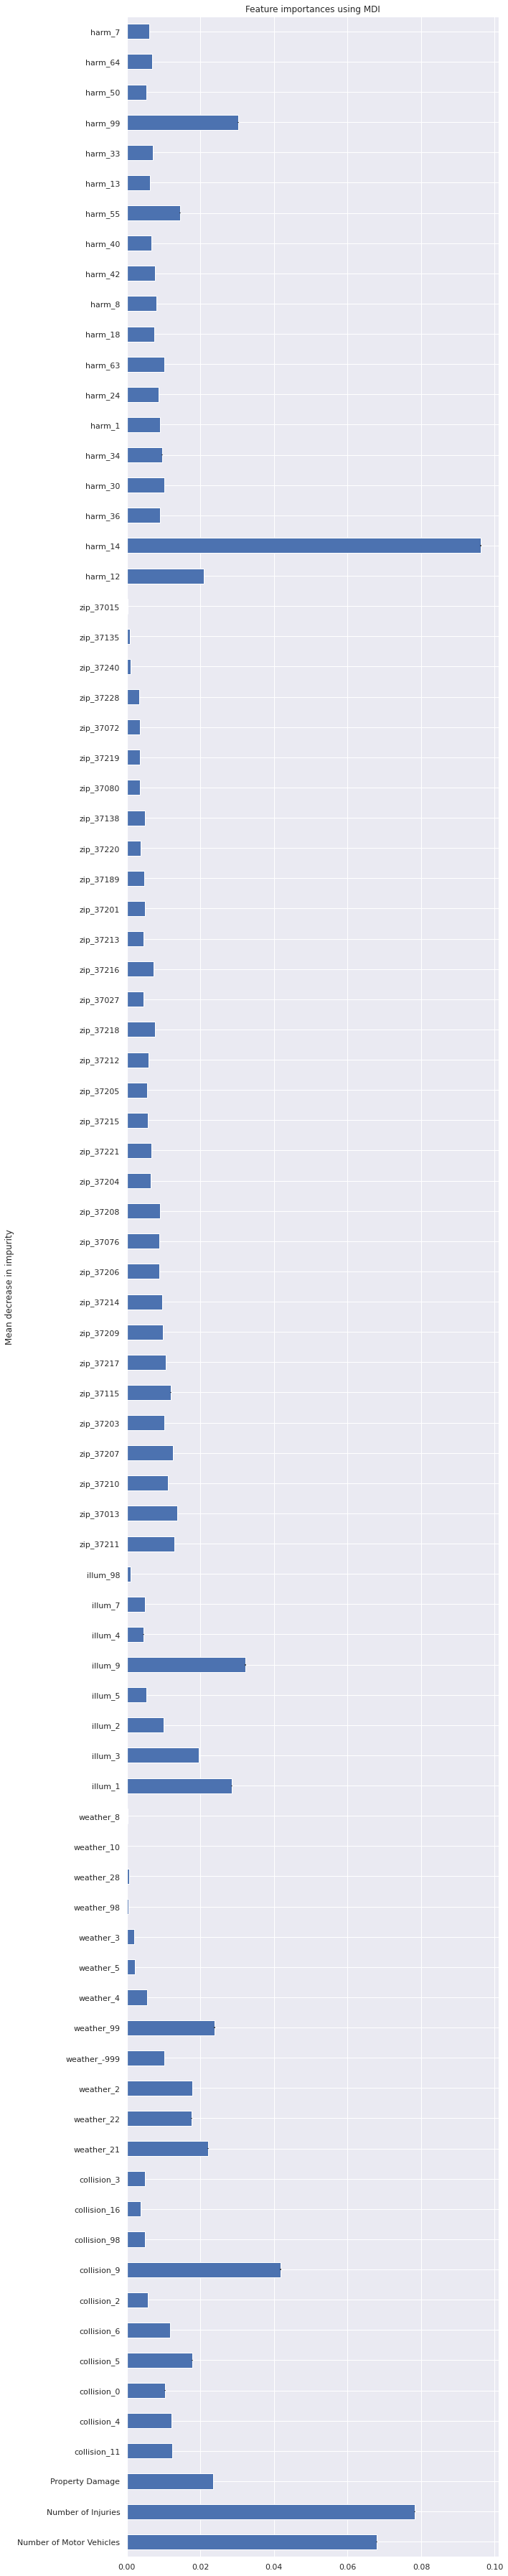

In [665]:
feature_names = X.columns#[f"feature {i}" for i in range(X.shape[1])]
importances = randomforest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomforest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

pyplot.rcParams['figure.figsize'] = (10,50)
fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### A try in XGBoost

In [667]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [668]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-rmse:0.48199	validation_1-rmse:0.48195
[1]	validation_0-rmse:0.46740	validation_1-rmse:0.46727
[2]	validation_0-rmse:0.45518	validation_1-rmse:0.45496
[3]	validation_0-rmse:0.44418	validation_1-rmse:0.44400
[4]	validation_0-rmse:0.43515	validation_1-rmse:0.43498
[5]	validation_0-rmse:0.42797	validation_1-rmse:0.42772
[6]	validation_0-rmse:0.42150	validation_1-rmse:0.42128
[7]	validation_0-rmse:0.41604	validation_1-rmse:0.41589
[8]	validation_0-rmse:0.41157	validation_1-rmse:0.41140
[9]	validation_0-rmse:0.40775	validation_1-rmse:0.40765
[10]	validation_0-rmse:0.40461	validation_1-rmse:0.40456
[11]	validation_0-rmse:0.40197	validation_1-rmse:0.40190
[12]	validation_0-rmse:0.39981	validation_1-rmse:0.39977
[13]	validation_0-rmse:0.39800	validation_1-rmse:0.39799
[14]	validation_0-rmse:0.39650	validation_1-rmse:0.39655
[15]	validation_0-rmse:0.39525	validation_1-rmse:0.39528
[16]	validation_0-rmse:0.39400	validation_1-rmse:0.39399
[17]	validation_0-rmse:0.39307	validation

[144]	validation_0-rmse:0.38083	validation_1-rmse:0.38219
[145]	validation_0-rmse:0.38080	validation_1-rmse:0.38218
[146]	validation_0-rmse:0.38079	validation_1-rmse:0.38216
[147]	validation_0-rmse:0.38077	validation_1-rmse:0.38216
[148]	validation_0-rmse:0.38076	validation_1-rmse:0.38216
[149]	validation_0-rmse:0.38075	validation_1-rmse:0.38215
[150]	validation_0-rmse:0.38072	validation_1-rmse:0.38214
[151]	validation_0-rmse:0.38071	validation_1-rmse:0.38213
[152]	validation_0-rmse:0.38069	validation_1-rmse:0.38211
[153]	validation_0-rmse:0.38067	validation_1-rmse:0.38211
[154]	validation_0-rmse:0.38066	validation_1-rmse:0.38210
[155]	validation_0-rmse:0.38065	validation_1-rmse:0.38210
[156]	validation_0-rmse:0.38063	validation_1-rmse:0.38208
[157]	validation_0-rmse:0.38062	validation_1-rmse:0.38207
[158]	validation_0-rmse:0.38061	validation_1-rmse:0.38206
[159]	validation_0-rmse:0.38059	validation_1-rmse:0.38205
[160]	validation_0-rmse:0.38058	validation_1-rmse:0.38204
[161]	validati

[286]	validation_0-rmse:0.37935	validation_1-rmse:0.38154
[287]	validation_0-rmse:0.37935	validation_1-rmse:0.38154
[288]	validation_0-rmse:0.37934	validation_1-rmse:0.38154
[289]	validation_0-rmse:0.37933	validation_1-rmse:0.38153
[290]	validation_0-rmse:0.37932	validation_1-rmse:0.38153
[291]	validation_0-rmse:0.37932	validation_1-rmse:0.38153
[292]	validation_0-rmse:0.37931	validation_1-rmse:0.38152
[293]	validation_0-rmse:0.37930	validation_1-rmse:0.38152
[294]	validation_0-rmse:0.37930	validation_1-rmse:0.38152
[295]	validation_0-rmse:0.37930	validation_1-rmse:0.38151
[296]	validation_0-rmse:0.37929	validation_1-rmse:0.38151
[297]	validation_0-rmse:0.37928	validation_1-rmse:0.38151
[298]	validation_0-rmse:0.37928	validation_1-rmse:0.38151
[299]	validation_0-rmse:0.37925	validation_1-rmse:0.38149
[300]	validation_0-rmse:0.37925	validation_1-rmse:0.38149
[301]	validation_0-rmse:0.37924	validation_1-rmse:0.38149
[302]	validation_0-rmse:0.37923	validation_1-rmse:0.38149
[303]	validati

/home/zimu/anaconda3/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

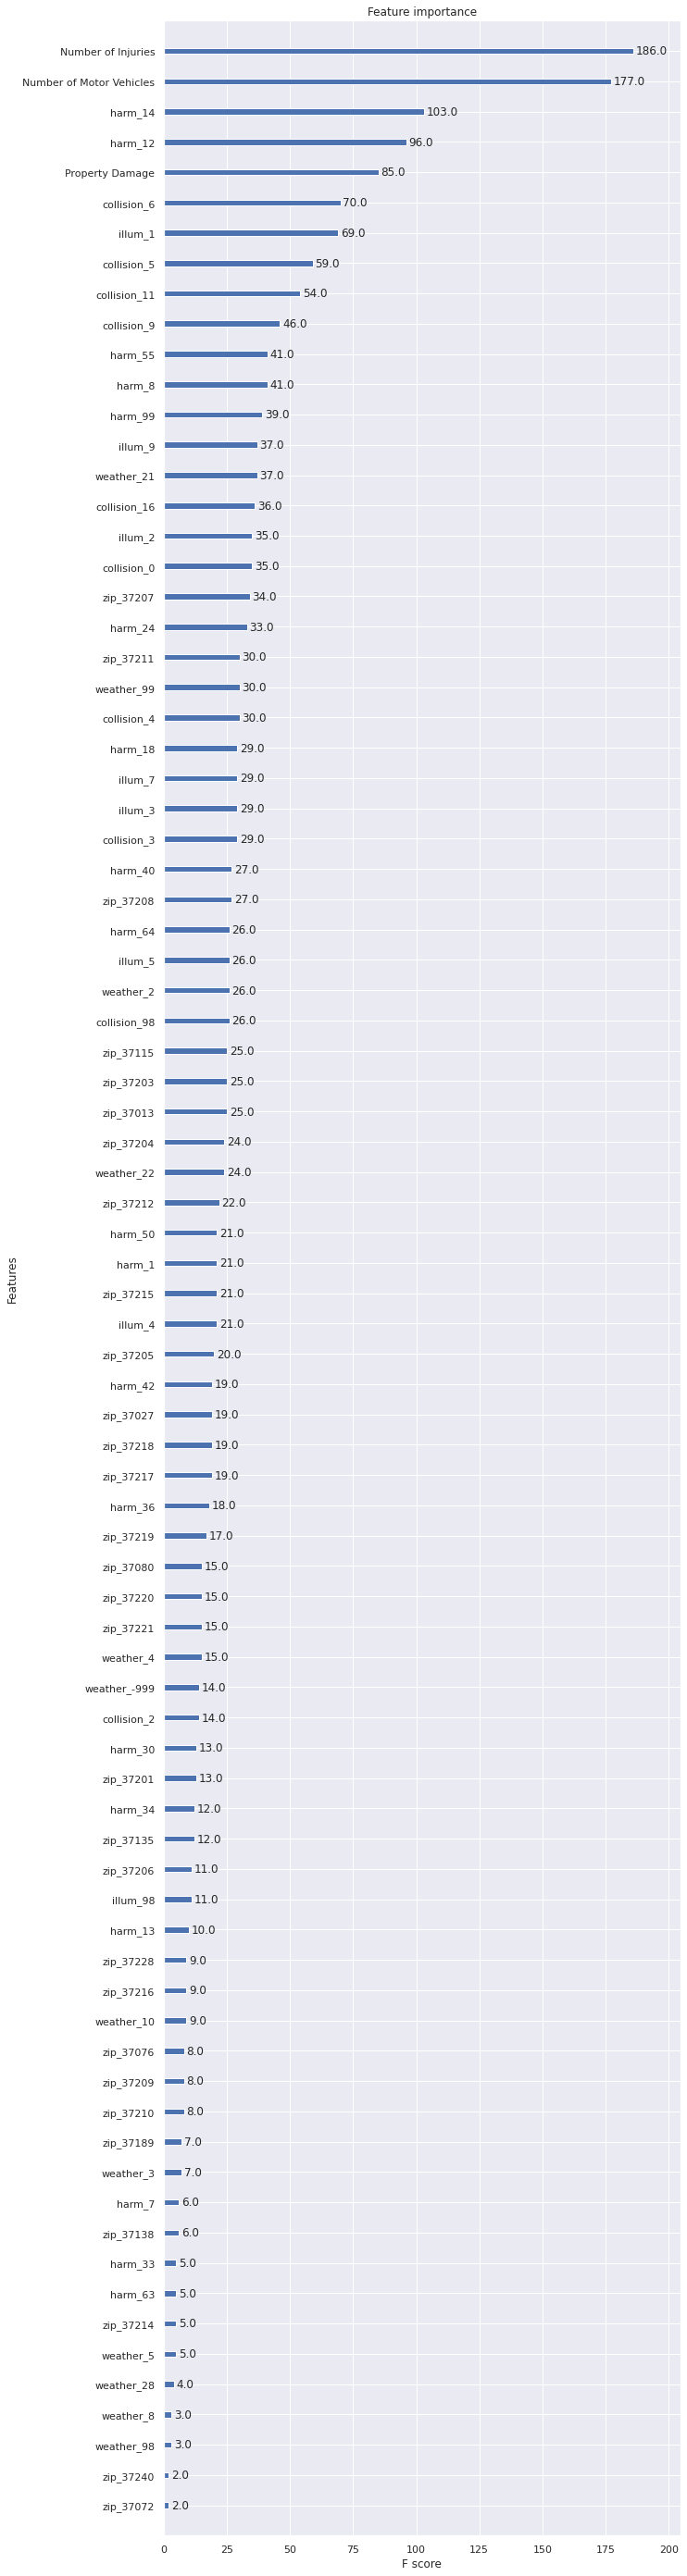

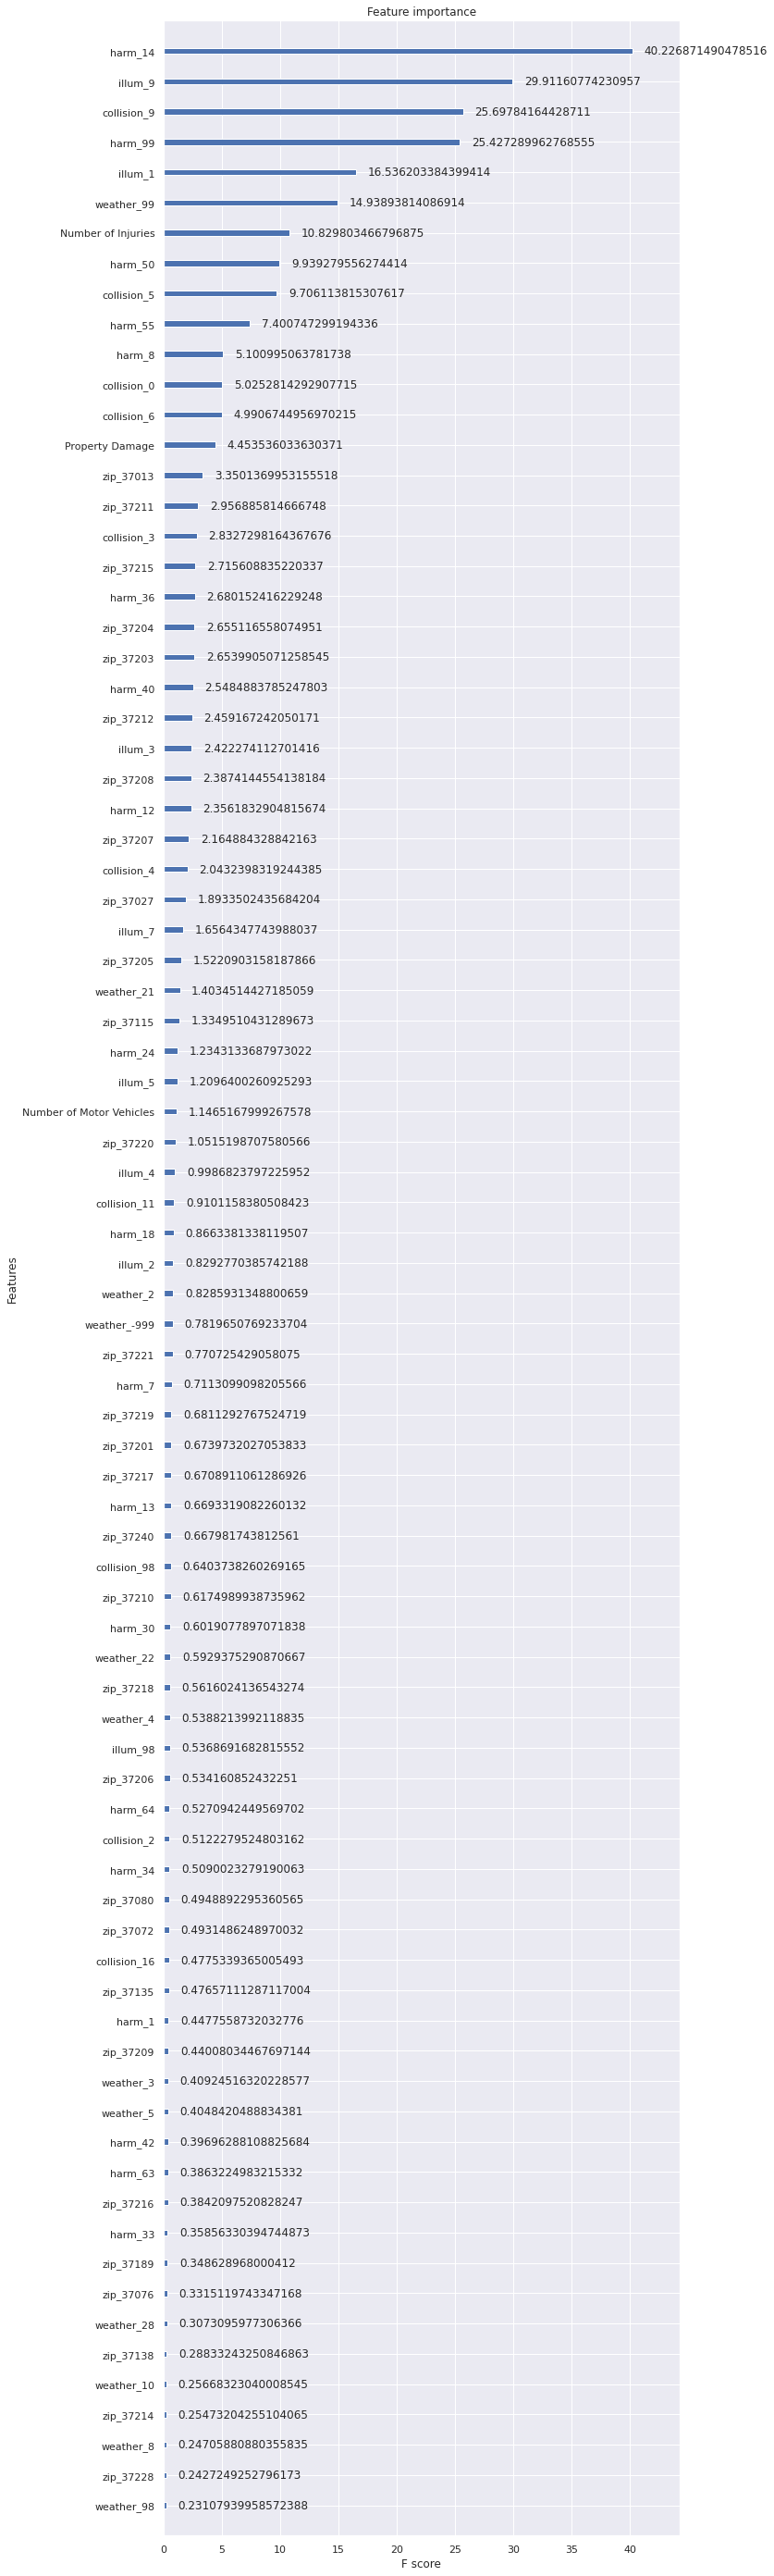

In [669]:
# predict using n_estimators with lowest validation error
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())
rmse(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test) 
# accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
pyplot.rcParams['figure.figsize'] = (10,50)
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

In [670]:
gbm.get_booster().get_score(importance_type='weight') #extract raw frequency scores

{'Number of Motor Vehicles': 177.0,
 'Number of Injuries': 186.0,
 'Property Damage': 85.0,
 'collision_11': 54.0,
 'collision_4': 30.0,
 'collision_0': 35.0,
 'collision_5': 59.0,
 'collision_6': 70.0,
 'collision_2': 14.0,
 'collision_9': 46.0,
 'collision_98': 26.0,
 'collision_16': 36.0,
 'collision_3': 29.0,
 'weather_21': 37.0,
 'weather_22': 24.0,
 'weather_2': 26.0,
 'weather_-999': 14.0,
 'weather_99': 30.0,
 'weather_4': 15.0,
 'weather_5': 5.0,
 'weather_3': 7.0,
 'weather_98': 3.0,
 'weather_28': 4.0,
 'weather_10': 9.0,
 'weather_8': 3.0,
 'illum_1': 69.0,
 'illum_3': 29.0,
 'illum_2': 35.0,
 'illum_5': 26.0,
 'illum_9': 37.0,
 'illum_4': 21.0,
 'illum_7': 29.0,
 'illum_98': 11.0,
 'zip_37211': 30.0,
 'zip_37013': 25.0,
 'zip_37210': 8.0,
 'zip_37207': 34.0,
 'zip_37203': 25.0,
 'zip_37115': 25.0,
 'zip_37217': 19.0,
 'zip_37209': 8.0,
 'zip_37214': 5.0,
 'zip_37206': 11.0,
 'zip_37076': 8.0,
 'zip_37208': 27.0,
 'zip_37204': 24.0,
 'zip_37221': 15.0,
 'zip_37215': 21.0,
 

### Feature code description
<div>
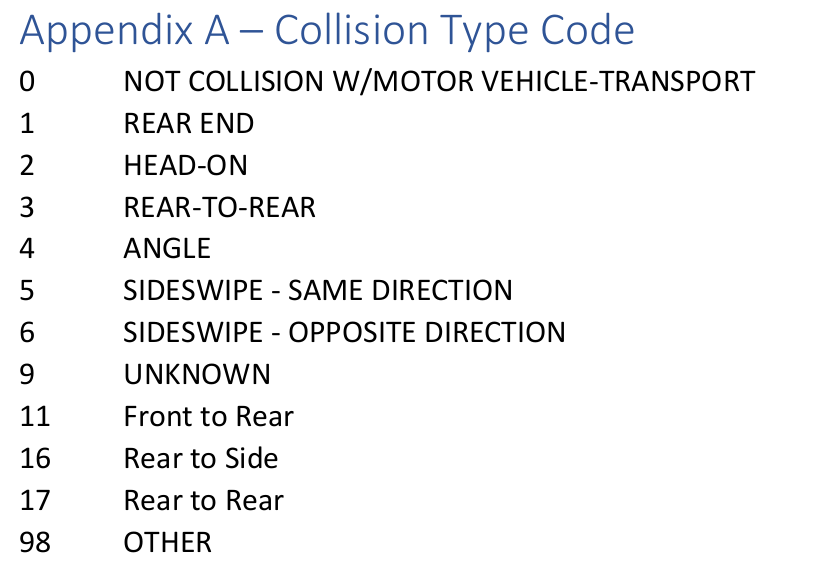
</div>

<div>
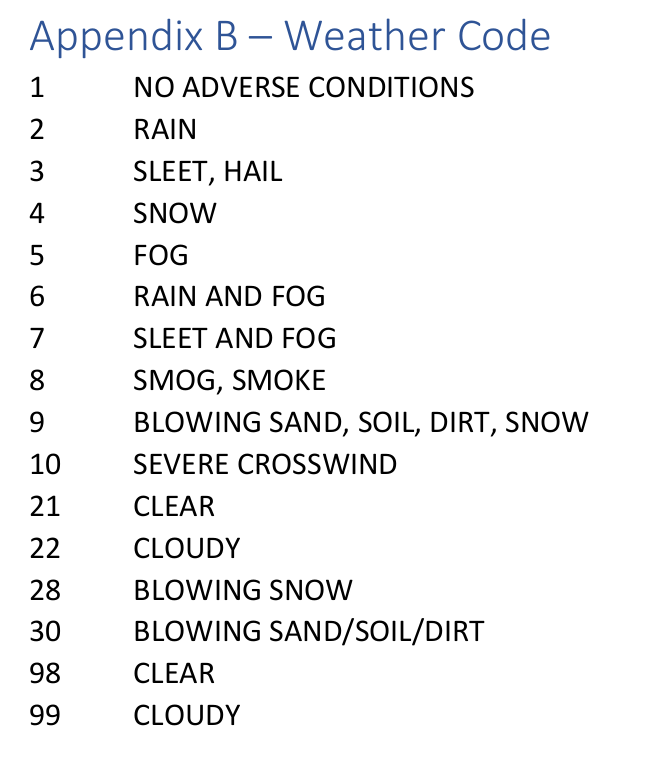
</div>

<div>
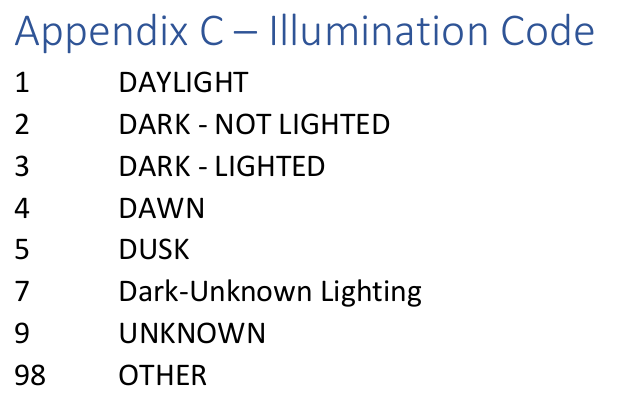
</div>

<div>
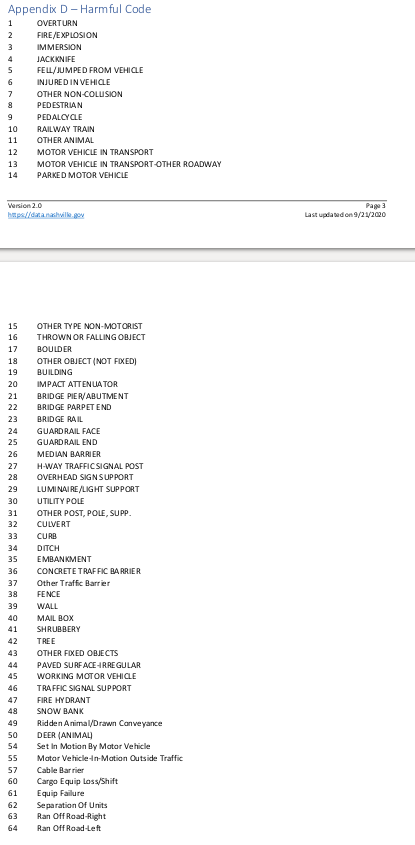
</div>

65 Cross Median <br /> 
66 Down Hill-Run Away<br /> 
67 Vehicle Airborne<br /> 
68 Cross Center Line<br /> 
70 GAS INHALATION<br /> 
71 EMBANKMENT EARTH<br /> 
72 EMBANKMENT ROCK/STONE/CONCRETE<br /> 
73 EMBANKMENT MATERIAL UNKNOWN<br /> 
74 Occupant Struck By Own Vehicle<br /> 
75 Bridge/Overhead Structure<br /> 
99 UNKNOWN MOST HARMFUL EVENT<br /> 